In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2025-01-21 02:28:57.385190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 02:28:57.385254: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 02:28:57.385301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 02:28:57.393571: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [3]:
train_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_training-set.csv")

In [4]:
test_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_testing-set.csv")


In [5]:
unsw_df=pd.concat([train_df, test_df], axis=0)

In [6]:
unsw_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
cicids_df = pd.read_csv("/home/work/gnssl/cleaned_improved_cicids2017.csv")

In [8]:
tmp=['Protocol', 'Flow Duration', 'Total Fwd Bytes', 'Total Bwd Bytes',
 'Total Fwd Packets', 'Total Bwd Packets', 'Fwd Packet Length Max',
 'Bwd Packet Length Max', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
 'Flow IAT Mean', 'Flow IAT Std', 'Total TCP Flow Time', 'SYN Flag Count',
 'ACK Flag Count', 'Average Packet Size', 'Fwd Bytes/Bulk Avg',
 'Bwd Bytes/Bulk Avg', 'Down/Up Ratio', 'Label']

print(len(tmp))

20


In [9]:
cicids_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags',
       'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', '

In [10]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [11]:
cicids_df

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5.296658e+06,20694308,6499982,0,0,0,BENIGN
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN
2,17,113976922,267,0,20447,0,153,37,76.580524,44.140625,...,10983883,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099966,6,64,1,1,0,0,0,0,0.000000,0.000000,...,0,0,0.0,0.000000e+00,0,0,0,0,64,Portscan
2099967,6,76,1,1,0,0,0,0,0.000000,0.000000,...,0,0,0.0,0.000000e+00,0,0,0,0,76,Portscan
2099968,6,81,1,1,0,0,0,0,0.000000,0.000000,...,0,0,0.0,0.000000e+00,0,0,0,0,81,Portscan
2099969,17,297,2,2,68,278,34,34,34.000000,0.000000,...,0,0,0.0,0.000000e+00,0,0,0,0,0,BENIGN


In [12]:
unsw_df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [13]:
# 이진분류
cicids_df['Label'] = cicids_df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# 변경된 데이터프레임 확인
print(cicids_df.head())

   Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0         0      119719148               231                  0   
1        17       65511209                 6                  6   
2        17      113976922               267                  0   
3        17       67037196                 8                  8   
4        17       68045057                 8                  8   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                           0                           0   
1                         288                         288   
2                       20447                           0   
3                         384                         384   
4                         384                         384   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      0                      0                0.000000   
1                     48                     48               48.000000   
2    

In [14]:
cicids_df['Protocol'].unique

<bound method Series.unique of 0           0
1          17
2          17
3          17
4          17
           ..
2099966     6
2099967     6
2099968     6
2099969    17
2099970     6
Name: Protocol, Length: 2099971, dtype: int64>

In [15]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [16]:
unsw_df['label'].value_counts()

1    164673
0     93000
Name: label, dtype: int64

In [17]:
# UNSW-NB15와 CIC-IDS 공통 컬럼 매핑 수정
unsw_to_cicids_mapping = {
    'proto': 'Protocol',
    'dur': 'Flow Duration',
    'sbytes': 'Total Fwd Packet',  # CIC-IDS의 'Total Fwd Packet'과 매핑
    'dbytes': 'Total Bwd packets',  # CIC-IDS의 'Total Bwd packets'과 매핑
    'sttl': 'FWD Init Win Bytes',  # CIC-IDS에서 'FWD Init Win Bytes'와 매핑
    'dttl': 'Bwd Init Win Bytes',  # CIC-IDS에서 'Bwd Init Win Bytes'와 매핑
    'smean': 'Fwd Packet Length Mean',
    'dmean': 'Bwd Packet Length Mean',
    'tcprtt': 'Total TCP Flow Time',
    'synack': 'SYN Flag Count',
    'ackdat': 'ACK Flag Count',
    'label': 'Label'
}

# UNSW-NB15에서 공통 컬럼 추출 및 이름 변경
new_unsw_df = unsw_df[unsw_to_cicids_mapping.keys()].copy()
new_unsw_df.rename(columns=unsw_to_cicids_mapping, inplace=True)

# CIC-IDS에서 공통 컬럼 추출
cicids_columns = unsw_to_cicids_mapping.values()
new_cicids_df = cicids_df[list(cicids_columns)].copy()

# 결과 출력
print("Extracted UNSW-NB15 Dataset Columns:")
print(new_unsw_df.head())

print("Extracted CIC-IDS Dataset Columns:")
print(new_cicids_df.head())

Extracted UNSW-NB15 Dataset Columns:
  Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      tcp       0.121478               258                172   
1      tcp       0.649902               734              42014   
2      tcp       1.623129               364              13186   
3      tcp       1.681642               628                770   
4      tcp       0.449454               534                268   

   FWD Init Win Bytes  Bwd Init Win Bytes  Fwd Packet Length Mean  \
0                 252                 254                      43   
1                  62                 252                      52   
2                  62                 252                      46   
3                  62                 252                      52   
4                 254                 252                      53   

   Bwd Packet Length Mean  Total TCP Flow Time  SYN Flag Count  \
0                      43             0.000000        0.000000   
1                  

In [18]:
new_unsw_df.columns==new_cicids_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [19]:
new_cicids_df

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Packet Length Mean,Bwd Packet Length Mean,Total TCP Flow Time,SYN Flag Count,ACK Flag Count,Label
0,0,119719148,231,0,0,0,0.000000,0.000000,0,0,0,0
1,17,65511209,6,6,0,0,48.000000,48.000000,0,0,0,0
2,17,113976922,267,0,0,0,76.580524,0.000000,0,0,0,0
3,17,67037196,8,8,0,0,48.000000,48.000000,0,0,0,0
4,17,68045057,8,8,0,0,48.000000,48.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2099966,6,64,1,1,1024,0,0.000000,0.000000,64,1,1,1
2099967,6,76,1,1,29200,0,0.000000,0.000000,76,1,1,1
2099968,6,81,1,1,1024,0,0.000000,0.000000,81,1,1,1
2099969,17,297,2,2,0,0,34.000000,139.000000,0,0,0,0


In [20]:
new_unsw_df

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Packet Length Mean,Bwd Packet Length Mean,Total TCP Flow Time,SYN Flag Count,ACK Flag Count,Label
0,tcp,0.121478,258,172,252,254,43,43,0.000000,0.000000,0.000000,0
1,tcp,0.649902,734,42014,62,252,52,1106,0.000000,0.000000,0.000000,0
2,tcp,1.623129,364,13186,62,252,46,824,0.111897,0.061458,0.050439,0
3,tcp,1.681642,628,770,62,252,52,64,0.000000,0.000000,0.000000,0
4,tcp,0.449454,534,268,254,252,53,45,0.128381,0.071147,0.057234,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82327,udp,0.000005,104,0,254,0,52,0,0.000000,0.000000,0.000000,0
82328,tcp,1.106101,18062,354,254,252,903,44,0.173208,0.100191,0.073017,0
82329,arp,0.000000,46,0,0,0,46,0,0.000000,0.000000,0.000000,0
82330,arp,0.000000,46,0,0,0,46,0,0.000000,0.000000,0.000000,0


In [21]:
new_cicids_df.columns == new_unsw_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [22]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_unsw_df['Protocol_Mapped'] = new_unsw_df['Protocol'].str.lower().map(protocol_map).fillna(0).astype(int)

new_unsw_df['Protocol'] = new_unsw_df['Protocol_Mapped']
new_unsw_df = new_unsw_df.drop(labels='Protocol_Mapped', axis=1)

In [23]:
cicids_df.shape

(2099971, 83)

In [24]:
cicids_df.isnull().values.any()

False

In [25]:
cicids_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5.296658e+06,20694308,6499982,0,0,0,0
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,0
2,17,113976922,267,0,20447,0,153,37,76.580524,44.140625,...,10983883,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,0
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,0
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,0


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CIC-IDS 데이터셋 PCA 적용
def apply_pca(df, n_components=2):
    scaler = StandardScaler()
    features = df.drop(columns=['Label'])  # 라벨 제외
    labels = df['Label']
    
    # 정규화
    features_scaled = scaler.fit_transform(features)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)
    
    # PCA 결과 데이터프레임 생성
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['Label'] = labels.reset_index(drop=True)
    
    # 주성분 설명력
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for {n_components} components: {explained_variance}")
    
    return pca_df, explained_variance

# CIC-IDS PCA
print("CIC-IDS PCA 적용")
cicids_pca_df, cicids_variance = apply_pca(new_cicids_df, n_components=11)

# UNSW-NB15 PCA
print("UNSW-NB15 PCA 적용")
unsw_pca_df, unsw_variance = apply_pca(new_unsw_df, n_components=11)

# 결과 출력
print("CIC-IDS PCA 데이터셋")
print(cicids_pca_df.head())

print("UNSW-NB15 PCA 데이터셋")
print(unsw_pca_df.head())


CIC-IDS PCA 적용
Explained variance ratio for 11 components: [2.73676887e-01 2.58504500e-01 1.11198076e-01 9.29704532e-02
 7.79033224e-02 7.67921433e-02 5.72957754e-02 3.81429356e-02
 1.34300536e-02 8.49910405e-05 8.62934258e-07]
UNSW-NB15 PCA 적용
Explained variance ratio for 11 components: [3.19352203e-01 1.65398074e-01 1.21432883e-01 9.08021867e-02
 8.23443862e-02 7.05184568e-02 6.17037101e-02 3.68945317e-02
 2.97979666e-02 2.17556022e-02 3.71213719e-32]
CIC-IDS PCA 데이터셋
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.387168 -0.749032  1.363526  1.193292  1.441241 -2.737477 -0.727562   
1 -0.273762  1.126891  1.035871  0.424074  0.920467 -1.093111 -0.765415   
2  0.006338  0.815067  1.936245  0.704010  1.723546 -1.812135 -1.285274   
3 -0.267885  1.116522  1.057799  0.436009  0.941836 -1.121465 -0.782816   
4 -0.265489  1.109290  1.072287  0.443904  0.955955 -1.140202 -0.794333   

        PC8       PC9      PC10      PC11  Label  
0  0.413088 -1.945900  

In [27]:
X_train_normal = unsw_pca_df[cicids_pca_df['Label'] == 0]


/tmp/ipykernel_1629/2358585744.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_normal = unsw_pca_df[cicids_pca_df['Label'] == 0]


In [28]:
X_train_normal.shape

(257673, 12)

In [29]:
X_test = cicids_pca_df

In [30]:
y_train_normal = X_train_normal['Label']
X_train_normal= X_train_normal.drop(labels='Label', axis=1)

y_test = X_test['Label']
X_test= X_test.drop(labels='Label', axis=1)

In [31]:
X_train_normal.dtypes

PC1     float64
PC2     float64
PC3     float64
PC4     float64
PC5     float64
PC6     float64
PC7     float64
PC8     float64
PC9     float64
PC10    float64
PC11    float64
dtype: object

In [32]:
X_train_normal

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-0.031023,-0.361961,-0.140868,0.225090,-0.682280,-0.190432,0.792928,-1.109791,-0.925235,-0.759554,8.914735e-14
1,0.245464,3.473814,-0.655903,-0.751026,-0.102873,0.342704,0.179523,-2.395473,0.600003,-0.525967,-6.558428e-15
2,1.889315,2.431824,-0.768601,-0.498557,-0.016496,0.666985,-0.165994,-1.349599,0.528157,-0.260991,2.631062e-15
3,0.026425,0.727627,-0.123278,-0.502453,-0.720762,0.273146,-0.060256,-0.440106,-1.556936,-0.806068,2.385583e-14
4,1.921421,-0.664662,-0.425112,0.439180,-0.297037,0.083001,0.546740,-0.467476,-0.332084,-0.377639,-1.009918e-13
...,...,...,...,...,...,...,...,...,...,...,...
257668,-1.405795,-0.941986,-0.234236,0.463309,0.760717,0.259112,-0.072081,-0.093424,0.122905,0.038381,4.312904e-18
257669,3.098654,-1.066953,1.646881,-1.341941,0.621815,-2.422903,-0.390283,-0.244682,0.454901,-0.226755,-1.834277e-16
257670,-0.817296,1.023508,-0.180435,-0.840852,-1.368339,0.308410,0.060954,1.405316,-0.628612,0.073056,-4.686578e-17
257671,-0.817296,1.023508,-0.180435,-0.840852,-1.368339,0.308410,0.060954,1.405316,-0.628612,0.073056,-5.646300e-17


In [33]:
X_test = X_test[X_train_normal.columns]

In [34]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history

2025-01-21 02:29:23.058027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2025-01-21 02:29:23.060215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 11)                22        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 11)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2025-01-21 02:29:25.467806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-21 02:29:26.162013: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f006d81f9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-21 02:29:26.162056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-21 02:29:26.162063: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-21 02:29:26.166781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-21 02:29:26.247773: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7248/7248 [==============================] - 49s 6ms/step - loss: 0.6583 - accuracy: 0.9565 - val_loss: 0.4382 - val_accuracy: 0.9896
Epoch 2/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.3646 - accuracy: 0.9775 - val_loss: 0.3038 - val_accuracy: 0.9422
Epoch 3/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.3675 - accuracy: 0.9781 - val_loss: 0.0915 - val_accuracy: 0.9936
Epoch 4/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.2383 - accuracy: 0.9832 - val_loss: 0.0687 - val_accuracy: 0.9947
Epoch 5/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.4240 - accuracy: 0.9834 - val_loss: 0.0845 - val_accuracy: 0.9916
Epoch 6/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.2577 - accuracy: 0.9833 - val_loss: 0.3307 - val_accuracy: 0.9872
Epoch 7/50
7248/7248 [==============================] - 44s 6ms/step - loss: 0.1369 - accuracy: 0.9881 - val_loss: 0.0831 - val_accuracy: 0.9

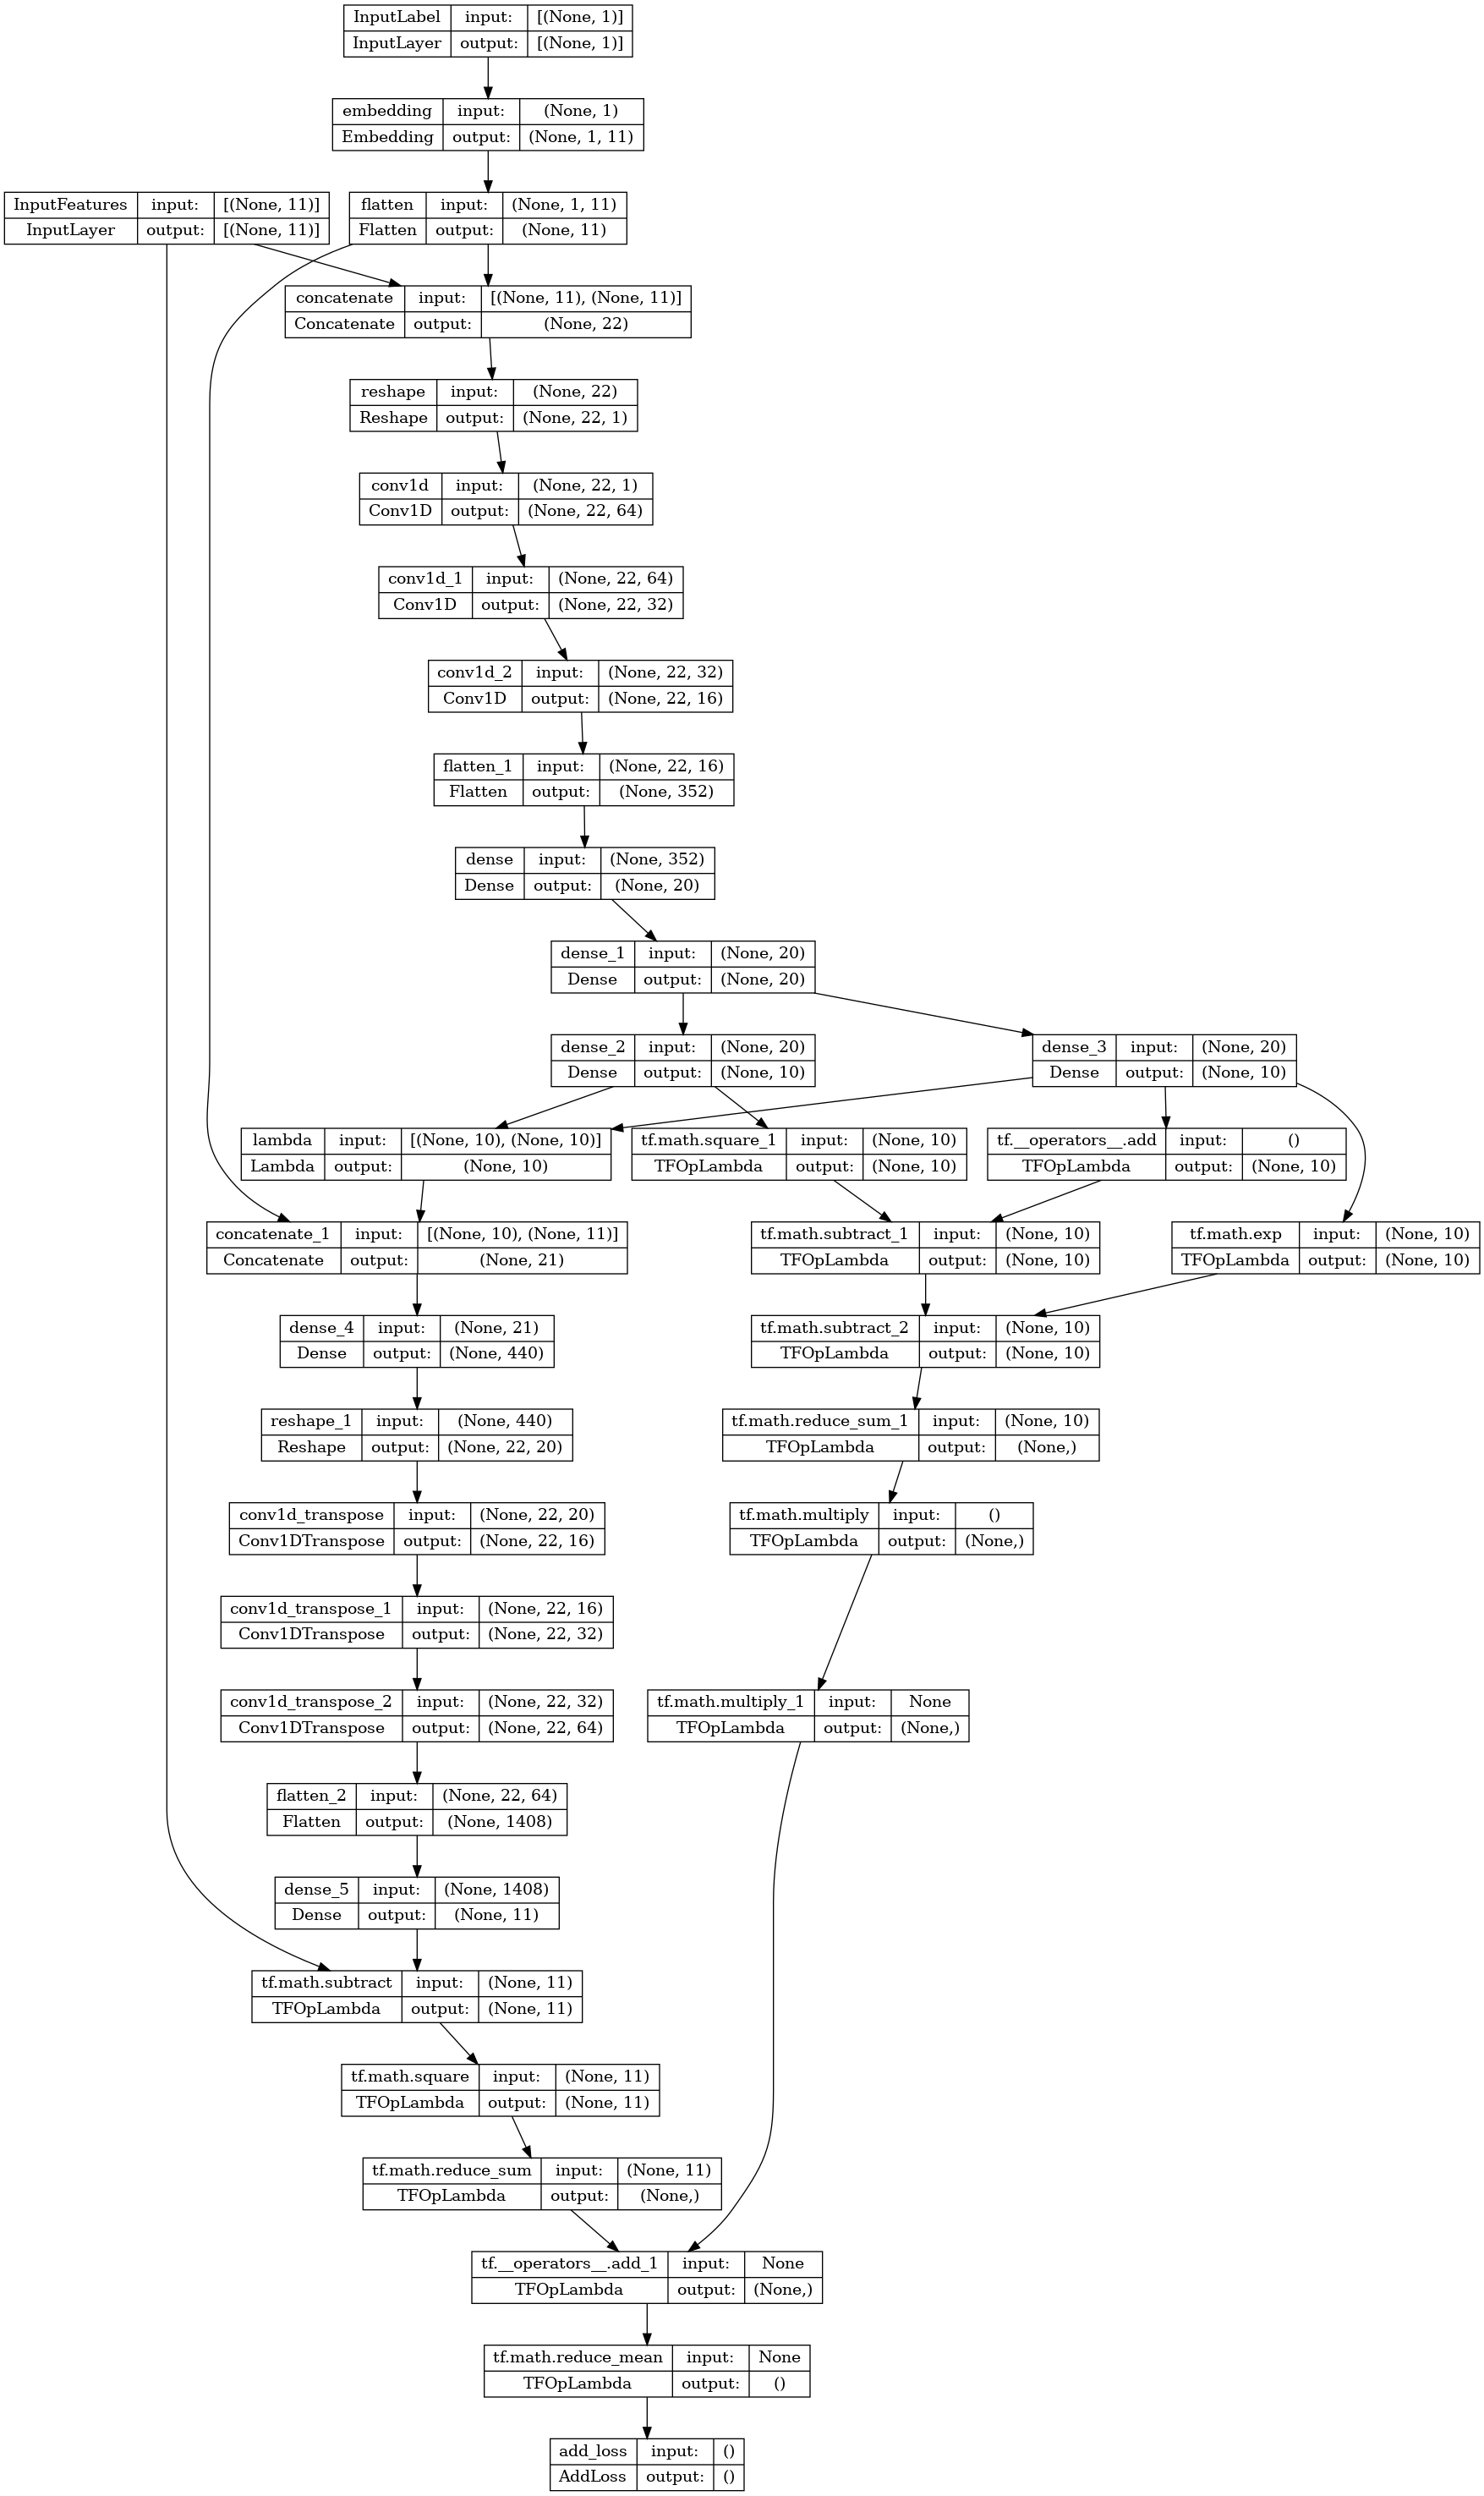

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

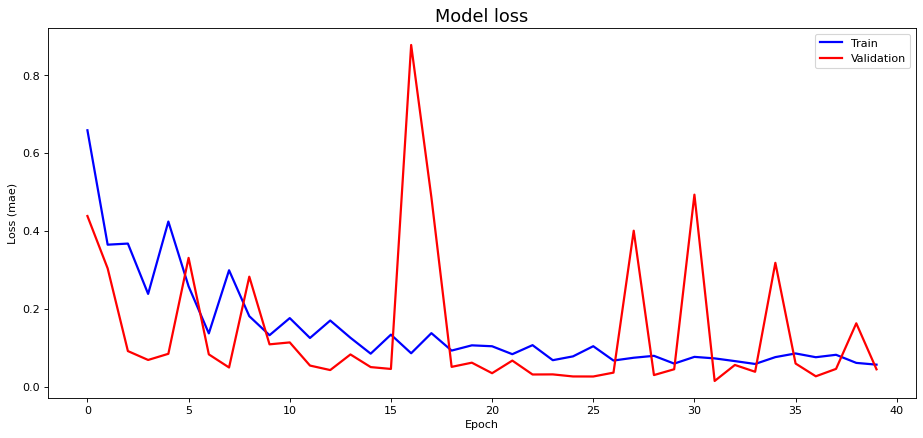

In [38]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [39]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [40]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

65625/65625 [==============================] - 121s 2ms/step


In [41]:
error_df

,reconstruction_error,true_class
0,1.035843,0
1,0.316035,0
2,0.250865,0
3,0.311591,0
4,0.302991,0
...,...,...
2099966,0.283934,1
2099967,0.160011,1
2099968,0.279272,1
2099969,0.074296,0


In [42]:
error_df[error_df['true_class']==0]

,reconstruction_error,true_class
0,1.035843,0
1,0.316035,0
2,0.250865,0
3,0.311591,0
4,0.302991,0
...,...,...
2099958,0.071421,0
2099962,0.073409,0
2099965,0.080829,0
2099969,0.074296,0


/tmp/ipykernel_1629/349485020.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


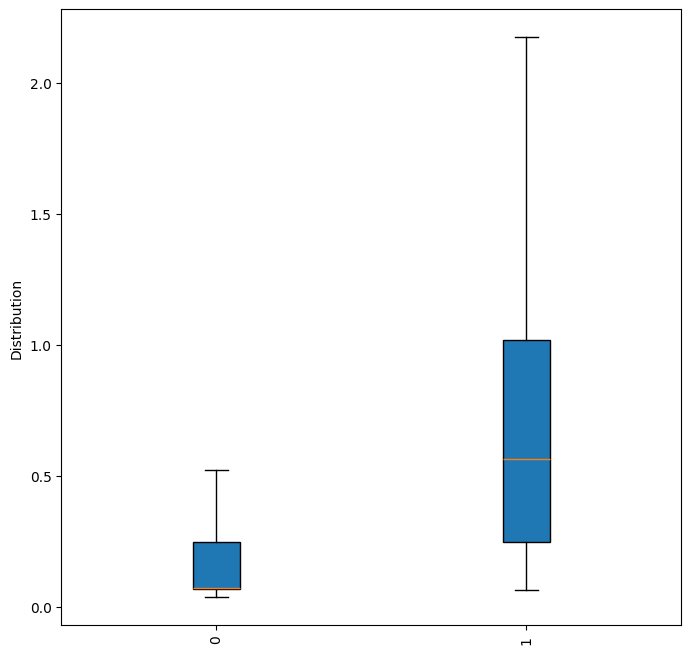

In [43]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


Best threshold: 0.15
Best F1 score: 0.6628411808929516


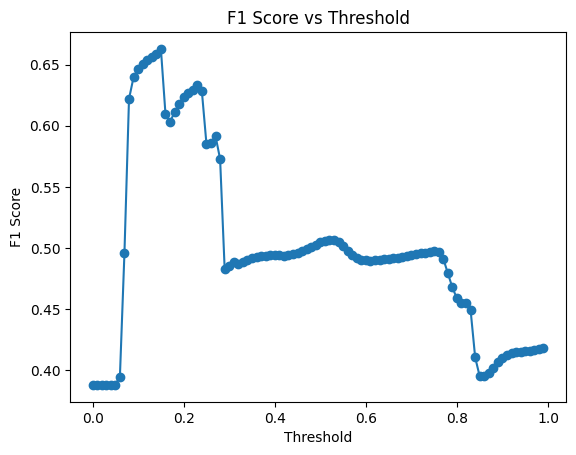

In [44]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0, 1, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [50]:
# 그래프 보고 threshold 결정 0.35
threshold =  0.15

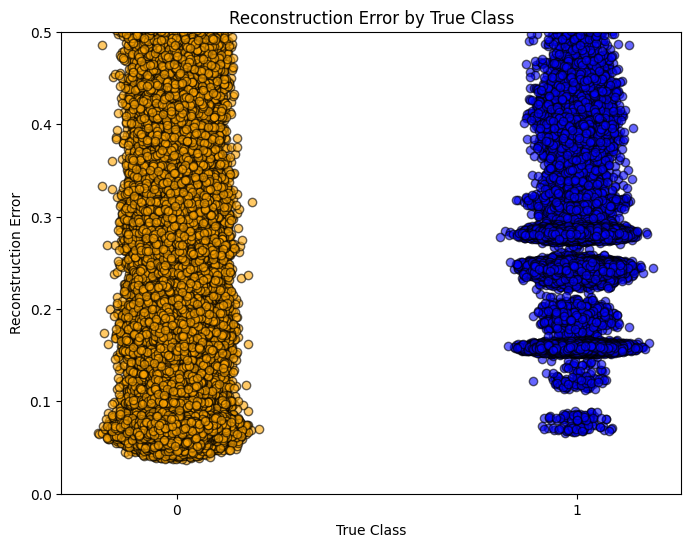

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.5)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


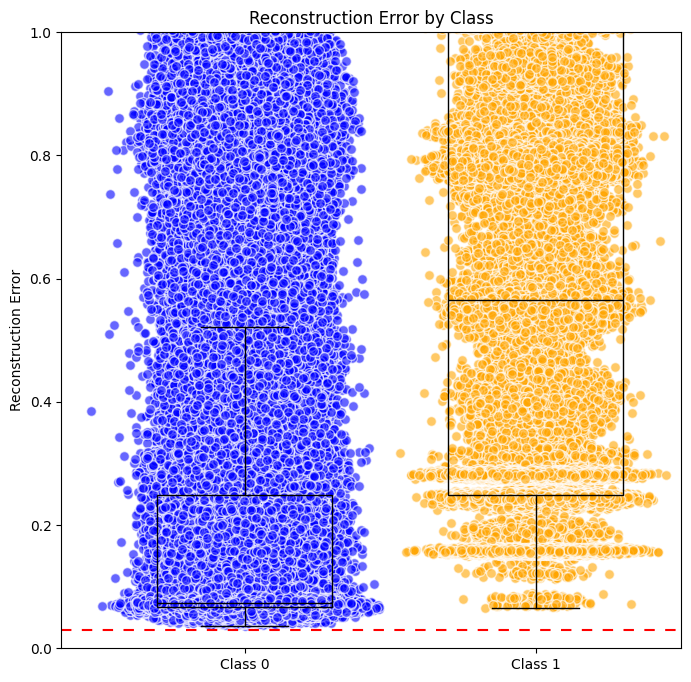

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=1)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


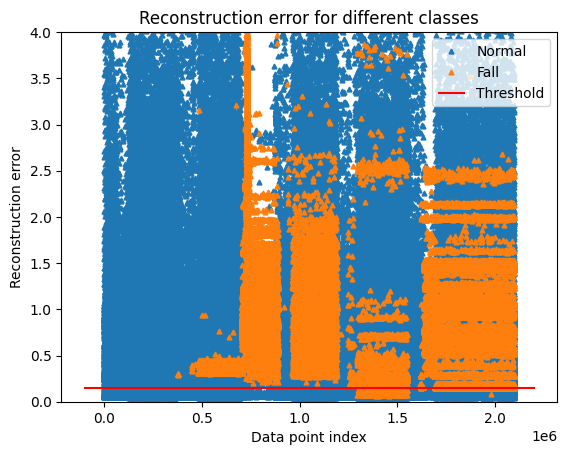

In [53]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

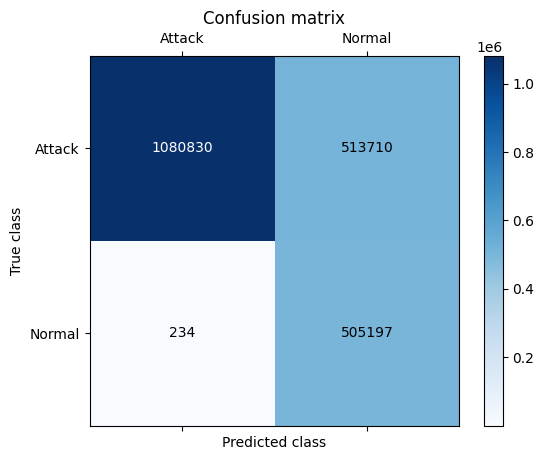

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [55]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.755261382180992
Precision : 0.49582248428953773
Recall : 0.9995370287932478
F1 : 0.6628411808929516


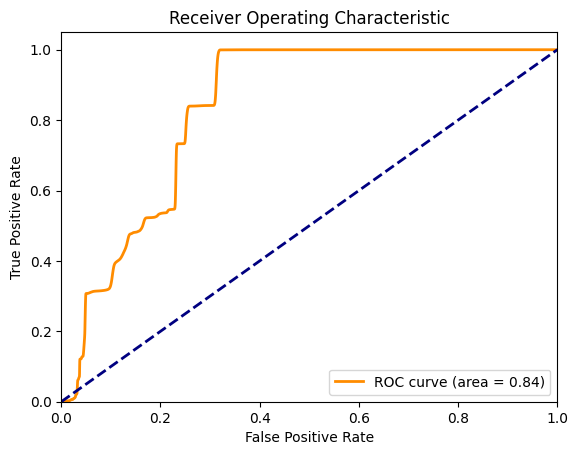

In [56]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


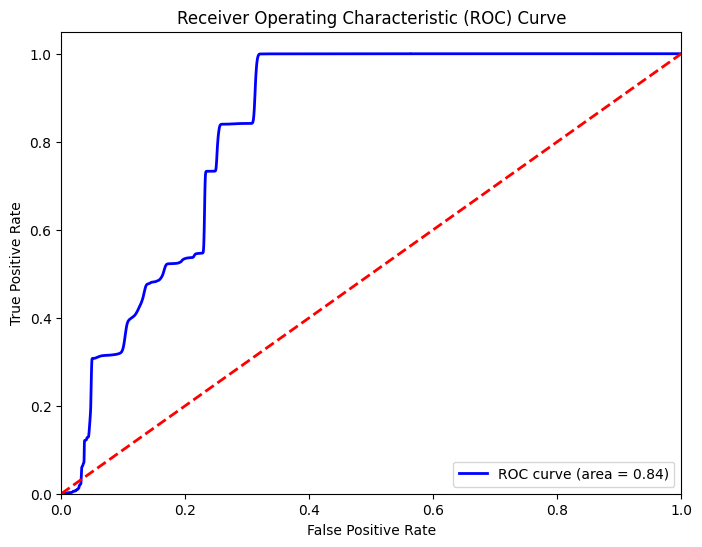

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [58]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.8357639456525849


In [59]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.755261382180992
Precision: 0.49582248428953773
Recall: 0.9995370287932478
F1 Score: 0.6628411808929516
